In [144]:
import matplotlib.pyplot as plt
import numpy as np
from util import *
import cv2 as cv

# This script uses example data. You will have to modify the
# loading code below to suit how you structure your data.

#MY CODE:
K  = np.loadtxt('../visualization_sample_data/K.txt')       # Intrinsic matrix.

I1 = cv.imread("../visualization_sample_data/query/IMG_8207.jpg", cv.IMREAD_GRAYSCALE) #quaryImage
I2 = cv.imread("../visualization_sample_data/query/IMG_8213.jpg", cv.IMREAD_GRAYSCALE) #trainImage

 
# Initiate SIFT detector
sift = cv.xfeatures2d.SIFT_create()

#SIFT ONLY TAKES 8-bit images - so converting here:
I1 = cv.normalize(I1, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
I2 = cv.normalize(I2, None, 0, 255, cv.NORM_MINMAX).astype('uint8')


# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(I1,None)
kp2, des2 = sift.detectAndCompute(I2,None)

# BFMatching of the descriptors/features
bf = cv.BFMatcher()
#matches = bf.knnMatch(des1,des2,k=2)
matches = bf.match(des1,des2)

#Pixel coordinates/point correspondences extracted:
uv1 = np.array([kp1[mat.queryIdx].pt for mat in matches]).T
uv2 = np.array([kp2[mat.trainIdx].pt for mat in matches]).T

print(uv1.shape)

(2, 28920)


In [129]:
print(uv1[0][:][:])
print(uv2[0][:][:])

[2.36827064e+00 2.37368870e+00 2.70380354e+00 ... 2.81171875e+03
 2.81185327e+03 2.81218164e+03]
[  48.85308456    2.87611699  181.92219543 ... 2770.84277344 1382.92858887
 2811.05761719]


In [ ]:
uv1_tilde = np.vstack((uv1, np.ones(uv1.shape[1])))
uv2_tilde = np.vstack((uv1, np.ones(uv1.shape[1])))

xy1 = np.linalg.inv(K)@uv1_tilde
xy2 = np.linalg.inv(K)@uv2_tilde
print(xy2[0:2,:])

In [ ]:
retval,rvec,tvec,inliers = cv.solvePnPRansac(xy1.T,xy2[0:2,:].T,K,None,iterationsCount=1000)
R,_ = cv.Rodrigues(rvec)
T_m2q = np.vstack((np.hstack((R,tvec)),np.array([0,0,0,1]))) 


[[    0]
 [    1]
 [    2]
 ...
 [28917]
 [28918]
 [28919]]
(4, 28920)


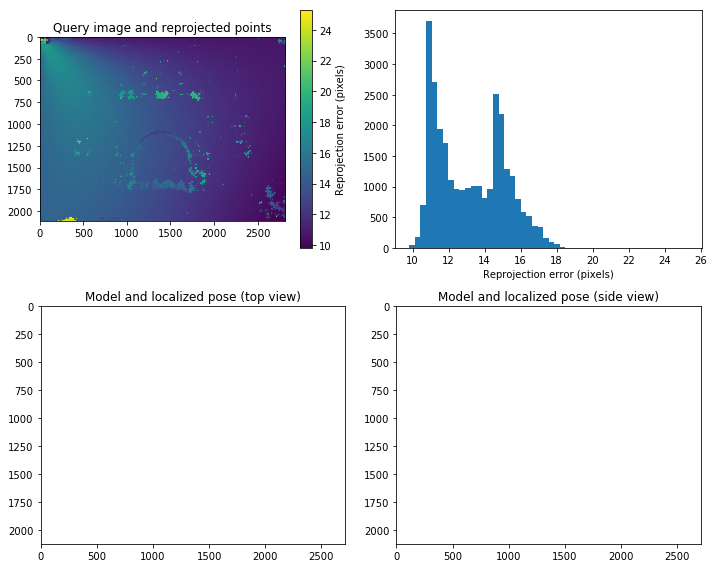

In [149]:
from triangulate_many import *

uv1_tilde = np.vstack((uv1, np.ones(uv1.shape[1])))
uv2_tilde = np.vstack((uv1, np.ones(uv1.shape[1])))

 
xy1 = np.linalg.inv(K)@uv1_tilde
xy2 = np.linalg.inv(K)@uv2_tilde


##MODEL Creation:
retval,rvec,tvec,inliers = cv.solvePnPRansac(xy1.T,xy2[0:2,:].T,K,None,iterationsCount=2000)
R,_ = cv.Rodrigues(rvec)

 

T_m2q = np.vstack((np.hstack((R,tvec)),np.array([0,0,0,1]))) 
u = uv1


P1 = np.hstack([np.eye(3),np.zeros((3,1))])
P2 = T_m2q[0:3,:]
X = triangulate_many(xy1, xy2, P1, P2)

I = I1 #Query


#TODO: 
#CREATE def localize()


"""
model = '../visualization_sample_data'
query = '../visualization_sample_data/query/IMG_8210'
K       = np.loadtxt(f'{model}/K.txt')       # Intrinsic matrix.
X       = np.loadtxt(f'{model}/X.txt')       # 3D points [shape: 4 x num_points].
T_m2q   = np.loadtxt(f'{query}_T_m2q.txt')   # Model-to-query transformation (produced by your localization script).
matches = np.loadtxt(f'{query}_matches.txt') # Initial 2D-3D matches (see usage code below).
inliers = np.loadtxt(f'{query}_inliers.txt') # Indices of inlier matches (see usage code below).
u       = np.loadtxt(f'{query}_u.txt')       # Image location of features detected in query image (produced by your localization script).
I       = plt.imread(f'{query}.jpg')         # Query image.
"""


assert X.shape[0] == 4
assert u.shape[0] == 2

# If you have colors for your point cloud model, then you can use this.
#c = np.loadtxt('../visualization_sample_data/c.txt') # RGB colors [shape: num_points x 3].
# Otherwise you can use this, which colors the points according to their Y.
c = None


# These control the location and the viewing target
# of the virtual figure camera, in the two views.
# You will probably need to change these to work
# with your scene.
lookfrom1 = np.array((0,-40,2))
lookat1   = np.array((0,0,1))
lookfrom2 = np.array((25,-5,10))
lookat2   = np.array((0,0,10))

# 'matches' is assumed to be a Nx2 array, where the
# first column is the index of the 2D point in the
# query image and the second column is the index of

matches = np.array(matches)

# its matched 3D point.
#assert matches.shape[1] == 2

#ISSUE PROBABLY HERE:

mat_u = [mat.queryIdx for mat in matches]
mat_x = [mat.queryIdx for mat in matches]

u_matches = u[:,mat_u]
X_matches = X[:,mat_x]


# 'inliers' is assumed to be a 1D array of indices
# of the good matches, e.g. as identified by your
# PnP+RANSAC strategy.
inliers = np.reshape(inliers, (inliers.shape[0]))
u_inliers = u_matches[:,inliers]
X_inliers = X_matches[:,inliers]
print(X_inliers.shape)

u_hat = project(K, T_m2q@X_inliers)
e = np.linalg.norm(u_hat - u_inliers, axis=0)

fig = plt.figure(figsize=(10,8))

plt.subplot(221)
plt.imshow(I)
plt.scatter(*u_hat, marker='+', c=e)
plt.xlim([0, I.shape[1]])
plt.ylim([I.shape[0], 0])
plt.colorbar(label='Reprojection error (pixels)')
plt.title('Query image and reprojected points')

plt.subplot(222)
plt.hist(e, bins=50)
plt.xlabel('Reprojection error (pixels)')

plt.subplot(223)
draw_model_and_query_pose(X, T_m2q, K, lookat1, lookfrom1, c=c)
plt.title('Model and localized pose (top view)')

plt.subplot(224)
draw_model_and_query_pose(X, T_m2q, K, lookat2, lookfrom2, c=c)
plt.title('Model and localized pose (side view)')

plt.tight_layout()
plt.show()


In [150]:
 #NEW TEST RUN:
import matplotlib.pyplot as plt
import numpy as np
from util import *
from triangulate_many import *
from estimate_E_ransac import *
from decompose_E import *
import cv2 as cv


K  = np.loadtxt('../visualization_sample_data/K.txt')       # Intrinsic matrix.
I1 = cv.imread("../visualization_sample_data/query/IMG_8207.jpg", cv.IMREAD_GRAYSCALE) #quaryImage
I2 = cv.imread("../visualization_sample_data/query/IMG_8213.jpg", cv.IMREAD_GRAYSCALE) #trainImage

# Initiate SIFT detector
sift = cv.xfeatures2d.SIFT_create()

#SIFT ONLY TAKES 8-bit images - so converting here:
I1 = cv.normalize(I1, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
I2 = cv.normalize(I2, None, 0, 255, cv.NORM_MINMAX).astype('uint8')


# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(I1,None)
kp2, des2 = sift.detectAndCompute(I2,None)

# BFMatching of the descriptors/features
bf = cv.BFMatcher()
matches = bf.match(des1,des2)


#Pixel coordinates/point correspondences extracted:
uv1 = np.array([kp1[mat.queryIdx].pt for mat in matches]).T
uv2 = np.array([kp2[mat.trainIdx].pt for mat in matches]).T


uv1_tilde = np.vstack((uv1, np.ones(uv1.shape[1])))
uv2_tilde = np.vstack((uv1, np.ones(uv1.shape[1])))

 
xy1 = np.linalg.inv(K)@uv1_tilde
xy2 = np.linalg.inv(K)@uv2_tilde



num_trials = get_num_ransac_trials(8, confidence=0.99, inlier_fraction=0.5)
E,inliers = estimate_E_ransac(xy1, xy2, K, distance_threshold=4, num_trials=num_trials)






Running RANSAC with 4 inlier threshold and 1176 trials...Done!
Found solution with 28920/28920 inliers


In [153]:
uv1 = uv1[:,inliers]
uv2 = uv2[:,inliers]
xy1 = xy1[:,inliers]
xy2 = xy2[:,inliers]

T4 = decompose_E(E)
best_num_visible = 0
for i, T in enumerate(T4):
    P1 = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])
    P2 = T[:3,:]
    X1 = triangulate_many(xy1, xy2, P1, P2)
    X2 = T@X1
    num_visible = np.sum((X1[2,:] > 0) & (X2[2,:] > 0))
    if num_visible > best_num_visible:
        best_num_visible = num_visible
        best_T = T
        best_X1 = X1
T = best_T
X = best_X1


[[ 1.00000000e+00 -3.43599029e-16 -2.72606179e-17 -9.94254180e-01]
 [ 4.57341010e-17  1.00000000e+00 -1.10057738e-16  2.30124658e-02]
 [ 8.55545315e-17 -1.09072285e-16  1.00000000e+00  1.04542105e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


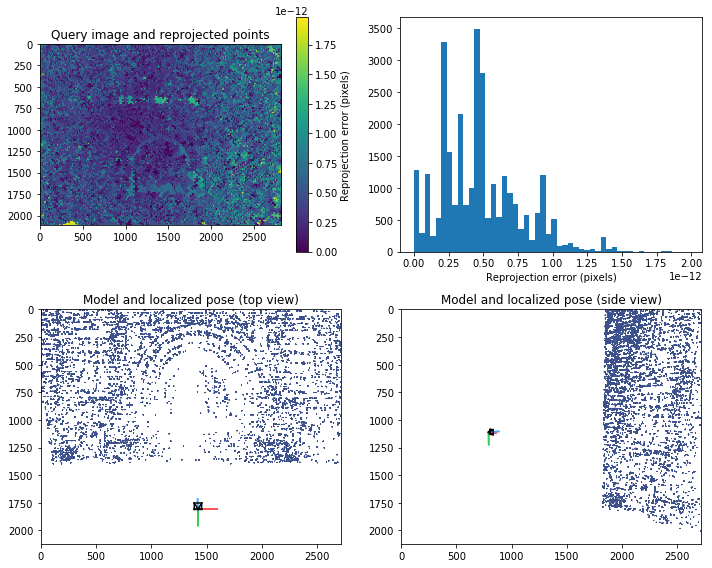

In [209]:
c = None
T_m2q = T

# These control the location and the viewing target
# of the virtual figure camera, in the two views.
# You will probably need to change these to work
# with your scene.
lookfrom1 = np.array((0,-20,-30))
lookat1   = np.array((0,0,40)) #0,0 in x-y axis gives camera in center for looking <t
lookfrom2 = np.array((45,-5,-30))
lookat2   = np.array((0,0,20))

# 'matches' is assumed to be a Nx2 array, where the
# first column is the index of the 2D point in the
# query image and the second column is the index of



# its matched 3D point.
#assert matches.shape[1] == 2


mat_u = [mat.queryIdx for mat in matches]
mat_x = [mat.queryIdx for mat in matches]

u_matches = u[:,mat_u]
X_matches = X[:,mat_x]


# 'inliers' is assumed to be a 1D array of indices
# of the good matches, e.g. as identified by your
# PnP+RANSAC strategy.
u_inliers = u_matches[:,inliers]
X_inliers = X_matches[:,inliers]

u_hat = project(K, T_m2q@X_inliers)
e = np.linalg.norm(u_hat - u_inliers, axis=0)

fig = plt.figure(figsize=(10,8))

plt.subplot(221)
plt.imshow(I)
plt.scatter(*u_hat, marker='+', c=e)
plt.xlim([0, I.shape[1]])
plt.ylim([I.shape[0], 0])
plt.colorbar(label='Reprojection error (pixels)')
plt.title('Query image and reprojected points')

plt.subplot(222)
plt.hist(e, bins=50)
plt.xlabel('Reprojection error (pixels)')

plt.subplot(223)
draw_model_and_query_pose(X, T_m2q, K, lookat1, lookfrom1, c=c)
plt.title('Model and localized pose (top view)')

plt.subplot(224)
draw_model_and_query_pose(X, T_m2q, K, lookat2, lookfrom2, c=c)
plt.title('Model and localized pose (side view)')

plt.tight_layout()
plt.show()